### 二次元リストから生成

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [2]:
import pandas as pd

In [3]:
# 1 各行を一つのリストとして並べる

list = [
    [1, 100, 0.33, 'AAA', 'AAA100'], 
    [2, 200, 0.67, 'BBB', 'BBB200'], 
    [3, 300, 1, 'CCC', 'CCC300'], 
    [4, 400, 1.33, 'DDD', 'DDD400'], 
    [5, 500, 1.67, 'EEE', 'EEE500'], 
    [6, 600, 2, 'FFF', 'FFF600']
]

# 2 表に変換
# pd.DataFrame(list) : pandasのDataFrameで表に変換
df = pd.DataFrame(list)
# 行名・列名は自動で割り振られた番号になっている

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

,col0,col1,col2,col3,col4
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [4]:
# 1 各行を一つのリストとして並べる
list = [
[1, 100, 0.33, 'AAA', 'AAA100'], 
[2, 200, 0.67, 'BBB', 'BBB200'], 
[3, 300, 1, 'CCC', 'CCC300'], 
[4, 400, 1.33, 'DDD', 'DDD400'], 
[5, 500, 1.67, 'EEE', 'EEE500'], 
[6, 600, 2, 'FFF', 'FFF600']]


#2 表に変換(オプションで行列名を指定)
ind = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']
col = ['col0', 'col1', 'col2', 'col3', 'col4']

df = pd.DataFrame(list, index=ind, columns=col)


df

,col0,col1,col2,col3,col4
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [5]:
# 1 各行を一つのリストにする
list = [
['row0', 1, 100, 0.33, 'AAA', 'AAA100'], 
['row1', 2, 200, 0.67, 'BBB', 'BBB200'], 
['row2', 3, 300, 1, 'CCC', 'CCC300'], 
['row3', 4, 400, 1.33, 'DDD', 'DDD400'], 
['row4', 5, 500, 1.67, 'EEE', 'EEE500'], 
['row5', 6, 600, 2, 'FFF', 'FFF600'], ]

# 2 表に変換
df = pd.DataFrame(list)

# 3 列名を変更
df.columns = ['', 'col0', 'col1', 'col2', 'col3', 'col4']

# 4 行名となる列を指定
df = df.set_index('')

df

,col0,col1,col2,col3,col4
,,,,,
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [6]:
# 1 各行ごとのリストを作成

listA = [1, 100, 0.33, 'AAA', 'AAA100']
listB = [2, 200, 0.67, 'BBB', 'BBB200']
listC = [3, 300, 1, 'CCC', 'CCC300']
listD = [4, 400, 1.33, 'DDD', 'DDD400']
listE = [5, 500, 1.67, 'EEE', 'EEE500']
listF = [6, 600, 2, 'FFF', 'FFF600']

# 2 まとめて表に変換

df = pd.DataFrame([listA, listB, listC, listD, listE, listF])

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

,col0,col1,col2,col3,col4
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [7]:
cg_c_data = return_dict_summary_fixed()

In [8]:
cg_c_data

{'processes': array([  1,   2,   4,   8,  16,  32,  64, 128, 256]),
 '.TAU_application': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'ALLOC_SPACE': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'CG': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'CONJ_GRAD': array([76., 76., 76., 76., 76., 76., 76., 76., 76.]),
 'ICNVRT': array([1984770., 2263540., 2821070., 3936140., 3936140., 3936140.,
        3936140., 3936140., 3936140.]),
 'INITIALIZE_MPI': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MAKEA': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Barrier()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Bcast()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Comm_rank()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Comm_size()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Finalize()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Init()': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'MPI_Irecv()': array([12236., 12483., 10982., 13984., 13984., 19988.,

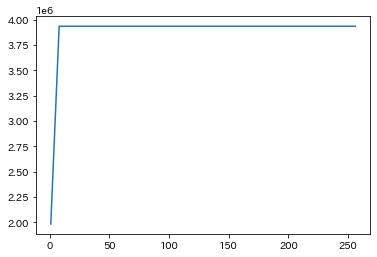

In [10]:
plt.plot(cg_c_data["processes"], cg_c_data["ICNVRT"])

In [11]:
x = cg_c_data["processes"]
y = cg_c_data["ICNVRT"]

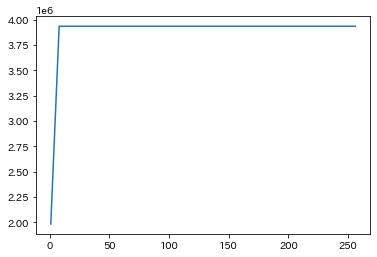

In [12]:
plt.plot(x,y)

In [12]:
def inverter_log10_func(x):
    return 10**x

class ModelLog10(ModelBase):
    
    def calc_lr(self):
        self.transformer_log10 = sp.FunctionTransformer(func=np.log10, inverse_func=inverter_log10_func)
        x_train_log10 = self.transformer_log10.transform(self.train_x)
        y_train_log10 = self.transformer_log10.transform(self.train_y)
        
        self.lr = LinearRegression()
        self.lr.fit(x_train_log10, y_train_log10)
        
    def calc_r2_score(self):
        train_x_log10 = self.transformer_log10.transform(self.train_x)
        train_y_predicted_log10 = self.lr.predict(train_x_log10)
        train_y_predicted = self.transformer_log10.inverse_transform(train_y_predicted_log10)
        self.r2_score = r2_score(self.train_y, train_y_predicted)
        
    def calc_mae_score(self):
        train_x_log10 = self.transformer_log10.transform(self.train_x)
        train_y_predicted_log10 = self.lr.predict(train_x_log10)
        train_y_predicted = self.transformer_log10.inverse_transform(train_y_predicted_log10)
        self.mae_score = mean_absolute_error(self.train_y, train_y_predicted)
        
    def calc_mse_score(self):
        train_x_log10 = self.transformer_log10.transform(self.train_x)
        train_y_predicted_log10 = self.lr.predict(train_x_log10)
        train_y_predicted = self.transformer_log10.inverse_transform(train_y_predicted_log10)
        self.mse_score = mean_squared_error(self.train_y, train_y_predicted)
        
    def calc_rmse_score(self):
        self.calc_mse_score()
        self.rmse_score = np.sqrt(self.mse_score)
        
    def calc_mape_score(self):
        train_x_log10 = self.transformer_log10.transform(self.train_x)
        train_y_predicted_log10 = self.lr.predict(train_x_log10)
        train_y_predicted = self.transformer_log10.inverse_transform(train_y_predicted_log10)
        self.mape_score = float(mape_score(self.train_y, train_y_predicted))
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)
        x_model_line_log10 = self.transformer_log10.transform(self.x_model_line)
        y_model_line_log10 = self.lr.predict(x_model_line_log10)
        self.y_model_line = self.transformer_log10.inverse_transform(y_model_line_log10)
        plt.plot(self.x_model_line, self.y_model_line, color="red")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        

In [13]:
cg_icnvrt_lr = ModelLog10(x, y, "CG", "ICNVRT")